# Chapter 05: Hierarchical Modeling with Partial Pooling

This notebook demonstrates one of vangja's most powerful features: **hierarchical Bayesian modeling** with partial pooling. This is inspired by:

- The [timeseers](https://github.com/MBrouns/timeseers) library, which extends Facebook Prophet with hierarchical modeling capabilities
- Matthijs Brouns' **PyMCon 2020** talk: [*Forecasting Hierarchical Time Series*](https://www.youtube.com/watch?v=appLxcMLT9Y)
- Matthijs Brouns' **PyData** talk: [*Hierarchical Time Series Forecasting*](https://www.youtube.com/watch?v=jo12CWZ00Lo)

## Why Hierarchical Modeling?

When forecasting multiple related time series, we often face a trade-off:

1. **Complete pooling** (`pool_type="complete"`): All series share the same parameters. This is useful when series are very similar, but ignores individual differences.

2. **No pooling** (`pool_type="individual"`): Each series has independent parameters. This captures individual differences, but doesn't leverage shared patterns and can overfit with limited data.

3. **Partial pooling** (`pool_type="partial"`): Parameters are drawn from a shared distribution (hyperprior). This allows series to "borrow strength" from each other while still capturing individual differences.

**Partial pooling is especially valuable when:**
- Some series have limited data or gaps
- Series belong to natural groups (e.g., stores in regions, products in categories)
- You want to share seasonal patterns while allowing different trends

## In This Notebook

We'll generate synthetic data representing multiple "product" time series with **random gaps** in the data, belonging to two seasonal groups ("summer" and "winter" products), plus an "all-year" product with minimal seasonality. We then compare:

- **Individual fitting** — Each series learns its own seasonality independently
- **Partial pooling** — Series share seasonal information hierarchically

The key insight is **not** in the aggregate metrics, but in **what happens inside the gaps**. Individual fitting tends to produce random, incorrect seasonal patterns in the missing intervals, while partial pooling leverages information from all series — including the all-year product — to produce coherent seasonal predictions even where data is missing.

## Setup and Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vangja import LinearTrend, FourierSeasonality
from vangja.datasets import generate_hierarchical_products
from vangja.utils import metrics, remove_random_gaps

print("Imports successful!")

Imports successful!


## Data Generation

We'll use synthetic time series data representing sales for different products, inspired by the [timeseers](https://github.com/MBrouns/timeseers) library. The key insight is that products within the same "group" share similar seasonal patterns:

- **Summer products** (3 series): Peak in summer months (positive yearly seasonality)
- **Winter products** (2 series): Peak in winter months (opposite yearly seasonality)
- **All-year products** (1 series): Minimal yearly seasonality

This scenario is ideal for hierarchical modeling: products within a group share seasonal patterns, but each product has its own trend and noise level.

We generate clean data using `generate_hierarchical_products()` and then introduce random gaps using `remove_random_gaps()` for each product except the `all_year` product. This simulates a real-world scenario where data collection may be interrupted — and more importantly, it lets us see how each modeling approach handles the missing intervals.

In [3]:
# Generate clean hierarchical product data with all 6 series (including all_year)
df_full, product_params = generate_hierarchical_products(seed=42, include_all_year=True)

# Apply random gaps to every series except all_year
np.random.seed(42)
df_parts = []
for name, params in product_params.items():
    series_data = df_full[df_full["series"] == name].copy()
    if params["group"] != "all_year":
        series_data = remove_random_gaps(series_data, n_gaps=4, gap_fraction=0.2)
    df_parts.append(series_data)

df = pd.concat(df_parts, ignore_index=True)

print(f"Date range: {df['ds'].min().date()} to {df['ds'].max().date()}")
print(f"Number of products: {len(product_params)}")
print(
    f"Summer products: {[k for k, v in product_params.items() if v['group'] == 'summer']}"
)
print(
    f"Winter products: {[k for k, v in product_params.items() if v['group'] == 'winter']}"
)
print(
    f"All-year products: {[k for k, v in product_params.items() if v['group'] == 'all_year']}"
)

Date range: 2018-01-01 to 2019-12-31
Number of products: 6
Summer products: ['summer_1', 'summer_2', 'summer_3']
Winter products: ['winter_1', 'winter_2']
All-year products: ['all_year']


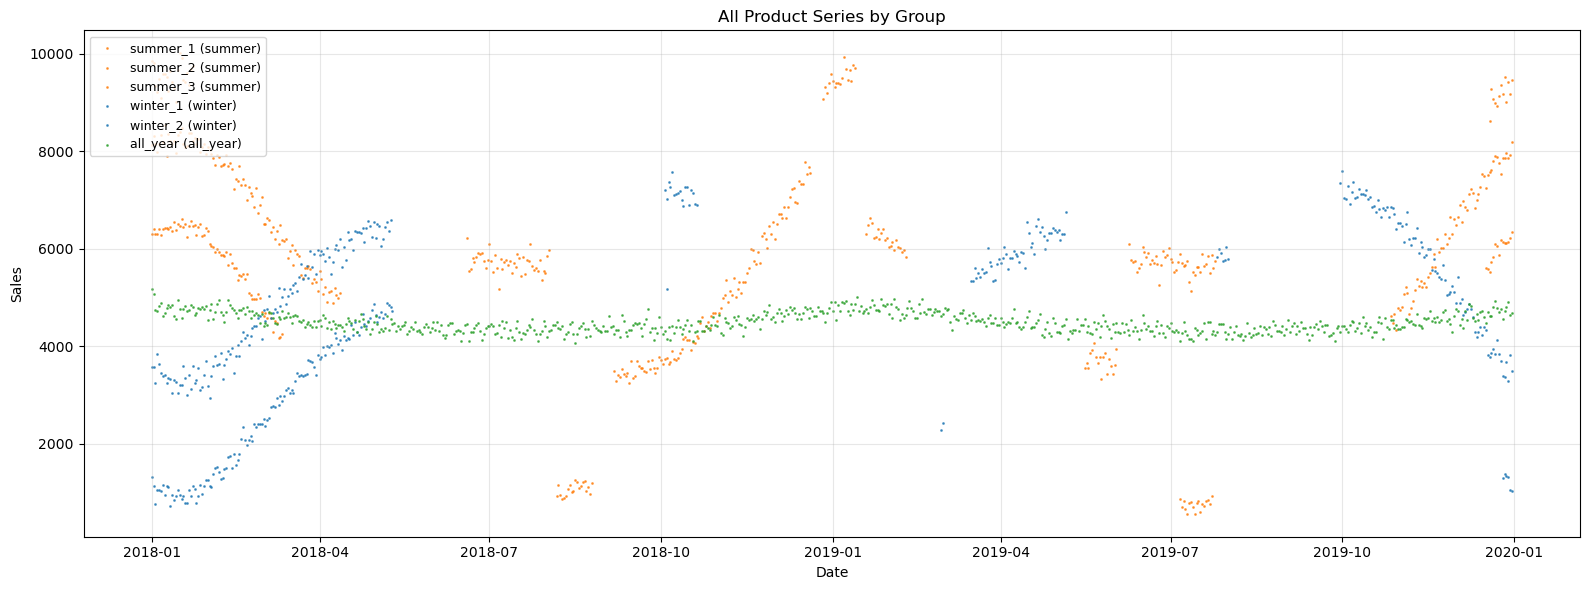

summer_1: y range = [3248, 8535], n_points = 292
summer_2: y range = [571, 6635], n_points = 146
summer_3: y range = [5136, 10006], n_points = 146
winter_1: y range = [722, 6032], n_points = 146
winter_2: y range = [2950, 7595], n_points = 292
all_year: y range = [4061, 5174], n_points = 730


In [4]:
# Visualize all series in a single plot with colors by group
# Using scatter plot to handle gaps in data (missing intervals)
fig, ax = plt.subplots(figsize=(16, 6))

# Define colors by group
group_colors = {"summer": "tab:orange", "winter": "tab:blue", "all_year": "tab:green"}

for name, params in product_params.items():
    series_data = df[df["series"] == name]
    color = group_colors[params["group"]]
    ax.scatter(
        series_data["ds"],
        series_data["y"],
        s=1,
        alpha=0.7,
        color=color,
        label=f"{name} ({params['group']})",
    )

ax.set_title("All Product Series by Group")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend(loc="upper left", fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print y-ranges and data availability for each series
for name, params in product_params.items():
    series_data = df[df["series"] == name]
    print(
        f"{name}: y range = [{series_data['y'].min():.0f}, {series_data['y'].max():.0f}], "
        f"n_points = {len(series_data)}"
    )

---

## Approach 1: Individual Fitting (No Pooling)

First, let's fit each series independently using `pool_type="individual"`. Each series gets its own:
- Trend parameters (slope, intercept)
- Changepoint deltas (via `delta_pool_type="individual"`)
- Seasonality coefficients
- Observation noise (via `sigma_pool_type="individual"`)

Since each series is fit independently, the model can learn arbitrary seasonality patterns for each series. With gaps in the data, the model has to infer what happens in those intervals purely from its own limited observations.

In [5]:
# Create model with individual pooling (no information sharing)
# Each series gets its own parameters including observation noise
model_individual = (
    LinearTrend(n_changepoints=10, pool_type="individual", delta_pool_type="individual")
    + FourierSeasonality(period=365.25, series_order=5, pool_type="individual")
    + FourierSeasonality(period=7, series_order=2, pool_type="individual")
)

print(f"Model: {model_individual}")

Model: LT(n=10,r=0.8,tm=None) + FS(p=365.25,n=5,tm=None) + FS(p=7,n=2,tm=None)


In [6]:
# Fit the individual model with sigma_pool_type="individual"
# This allows each series to have its own observation noise level
start_time = time.time()
model_individual.fit(
    df, method="mapx", scale_mode="individual", sigma_pool_type="individual"
)
time_individual = time.time() - start_time

print(f"Individual fitting time: {time_individual:.2f}s")
print(f"Group mapping: {model_individual.groups_}")

Output()

Individual fitting time: 3.45s
Group mapping: {0: 'all_year', 1: 'summer_1', 2: 'summer_2', 3: 'summer_3', 4: 'winter_1', 5: 'winter_2'}


In [7]:
# Generate fitted values (predictions on training dates)
fitted_individual = model_individual.predict(horizon=0, freq="D")

# Calculate metrics for each series on the full dataset
individual_metrics = []
for name in product_params.keys():
    group_code = [k for k, v in model_individual.groups_.items() if v == name][0]
    series_data = df[df["series"] == name]
    fitted_for_metrics = fitted_individual[["ds", f"yhat_{group_code}"]].copy()
    fitted_for_metrics.columns = ["ds", "yhat_0"]
    m = metrics(series_data, fitted_for_metrics, "complete")
    m.index = [name]
    individual_metrics.append(m)

individual_metrics_df = pd.concat(individual_metrics)
print("Individual Fitting Metrics (in-sample):")
display(individual_metrics_df)

Individual Fitting Metrics (in-sample):


,mse,rmse,mae,mape
summer_1,20102.984087,141.784992,114.201912,0.020858
summer_2,8165.110221,90.360999,73.274235,0.031729
summer_3,34680.253949,186.226351,144.627024,0.021537
winter_1,12182.269851,110.373320,90.463162,0.048426
winter_2,27768.034735,166.637435,131.741726,0.026308
all_year,10138.693980,100.691082,79.731824,0.017807


### What happens in the gaps?

The aggregate in-sample metrics above look reasonable, but they only measure fit quality **where we have data**. The real question is: **what does the model predict in the gaps where data is missing?**

When fitting individually, each series learns its yearly seasonal pattern from its own incomplete observations. With large gaps (20% of data removed, 4 times), the model may learn a yearly seasonality that is random and wrong — it fills in the gaps with whatever pattern fits the sparse data best, which can lead to erratic seasonal effects in the missing intervals.

Let's use the built-in `plot()` method to examine the individual model's predictions, paying close attention to the intervals where data is missing:

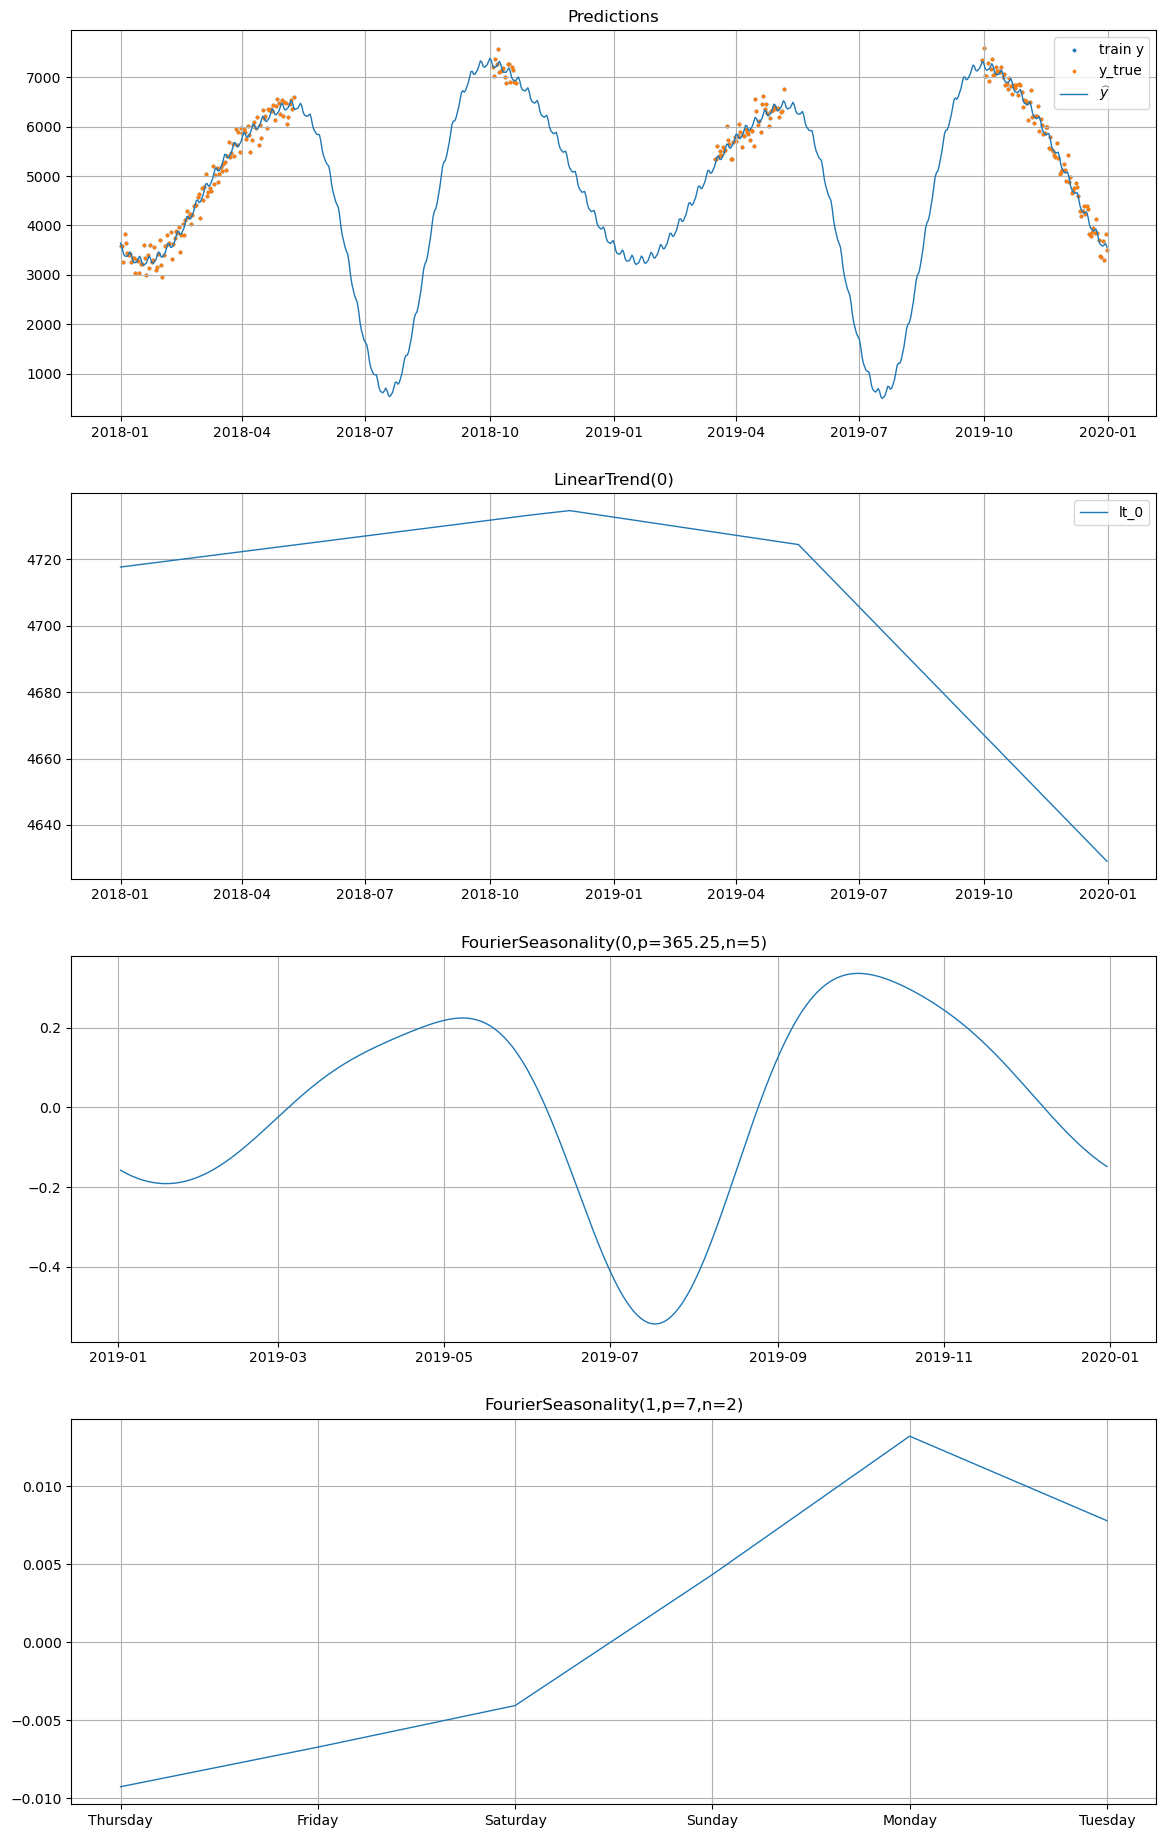

In [ ]:
# Plot individual model predictions for winter_2
# The y_true overlaid in orange shows where actual data exists;
# look at the gaps to see what the model "imagines" without data.
model_individual.plot(
    fitted_individual, series="winter_2", y_true=df[df["series"] == "winter_2"]
)

---

## Approach 2: Partial Pooling (Hierarchical)

Now let's use partial pooling with `pool_type="partial"`. In this approach:

- **Trend**: Each series has its own slope and intercept, but they're drawn from a shared distribution. This allows series to "borrow strength" from each other.
- **Changepoint Deltas**: We use `delta_pool_type="partial"` to also share changepoint information hierarchically.
- **Seasonality**: The Fourier coefficients are partially pooled with high `shrinkage_strength`, allowing series to strongly share seasonal patterns while still permitting individual variations.

The hierarchical structure is:
```
slope_shared ~ Normal(0, σ_slope)
slope[i] ~ Normal(slope_shared, σ_individual)
```

Crucially, **partial pooling shares seasonal information across all series**, including the `all_year` product which has complete data and minimal (but real) yearly seasonality. This means that even in the gaps of other series, the model can draw on the shared seasonal knowledge to produce coherent predictions — rather than inventing arbitrary patterns from sparse data.

In [10]:
# Create model with partial pooling (hierarchical)
# High shrinkage_strength on seasonality forces strong sharing of seasonal patterns
model_partial = (
    LinearTrend(
        n_changepoints=10,
        pool_type="partial",
        delta_pool_type="partial",
        shrinkage_strength=10,
    )
    + FourierSeasonality(
        period=365.25, series_order=5, pool_type="partial", shrinkage_strength=1000
    )
    + FourierSeasonality(
        period=7, series_order=2, pool_type="partial", shrinkage_strength=1000
    )
)

print(f"Model: {model_partial}")

Model: LT(n=10,r=0.8,tm=None) + FS(p=365.25,n=5,tm=None) + FS(p=7,n=2,tm=None)


In [11]:
# Fit the partial pooling model
start_time = time.time()
model_partial.fit(
    df, method="mapx", scale_mode="individual", sigma_pool_type="individual"
)
time_partial = time.time() - start_time

print(f"Partial pooling fitting time: {time_partial:.2f}s")
print(f"Group mapping: {model_partial.groups_}")

Output()

Partial pooling fitting time: 7.62s
Group mapping: {0: 'all_year', 1: 'summer_1', 2: 'summer_2', 3: 'summer_3', 4: 'winter_1', 5: 'winter_2'}


In [12]:
# Generate predictions
future_partial = model_partial.predict(horizon=0, freq="D")

# Calculate metrics for each series
partial_metrics = []
for name in product_params.keys():
    group_code = [k for k, v in model_partial.groups_.items() if v == name][0]
    test_series = df[df["series"] == name]
    future_for_metrics = future_partial[["ds", f"yhat_{group_code}"]].copy()
    future_for_metrics.columns = ["ds", "yhat_0"]
    m = metrics(test_series, future_for_metrics, "complete")
    m.index = [name]
    partial_metrics.append(m)

partial_metrics_df = pd.concat(partial_metrics)
print("Partial Pooling Metrics:")
display(partial_metrics_df)

Partial Pooling Metrics:


,mse,rmse,mae,mape
summer_1,20207.430070,142.152841,114.761139,0.020943
summer_2,8375.681566,91.518750,74.878657,0.032018
summer_3,34960.399048,186.977001,146.326295,0.021774
winter_1,12728.785675,112.821920,93.404084,0.049773
winter_2,27793.188897,166.712894,131.774282,0.026323
all_year,10149.853129,100.746479,79.753239,0.017812


### How partial pooling handles the gaps

Now compare the partial pooling model's predictions for the same series. Because the hierarchical model shares seasonal information across all 6 series — including the `all_year` product which has **no gaps** and a well-defined (albeit minimal) yearly pattern — the model is able to produce coherent seasonal predictions even in the missing intervals.

The `all_year` product acts as an anchor: its complete data coverage teaches the shared seasonal hyperprior about the overall yearly cycle. This information flows hierarchically to the winter and summer products, resulting in smoother and more realistic seasonal patterns in the gaps.

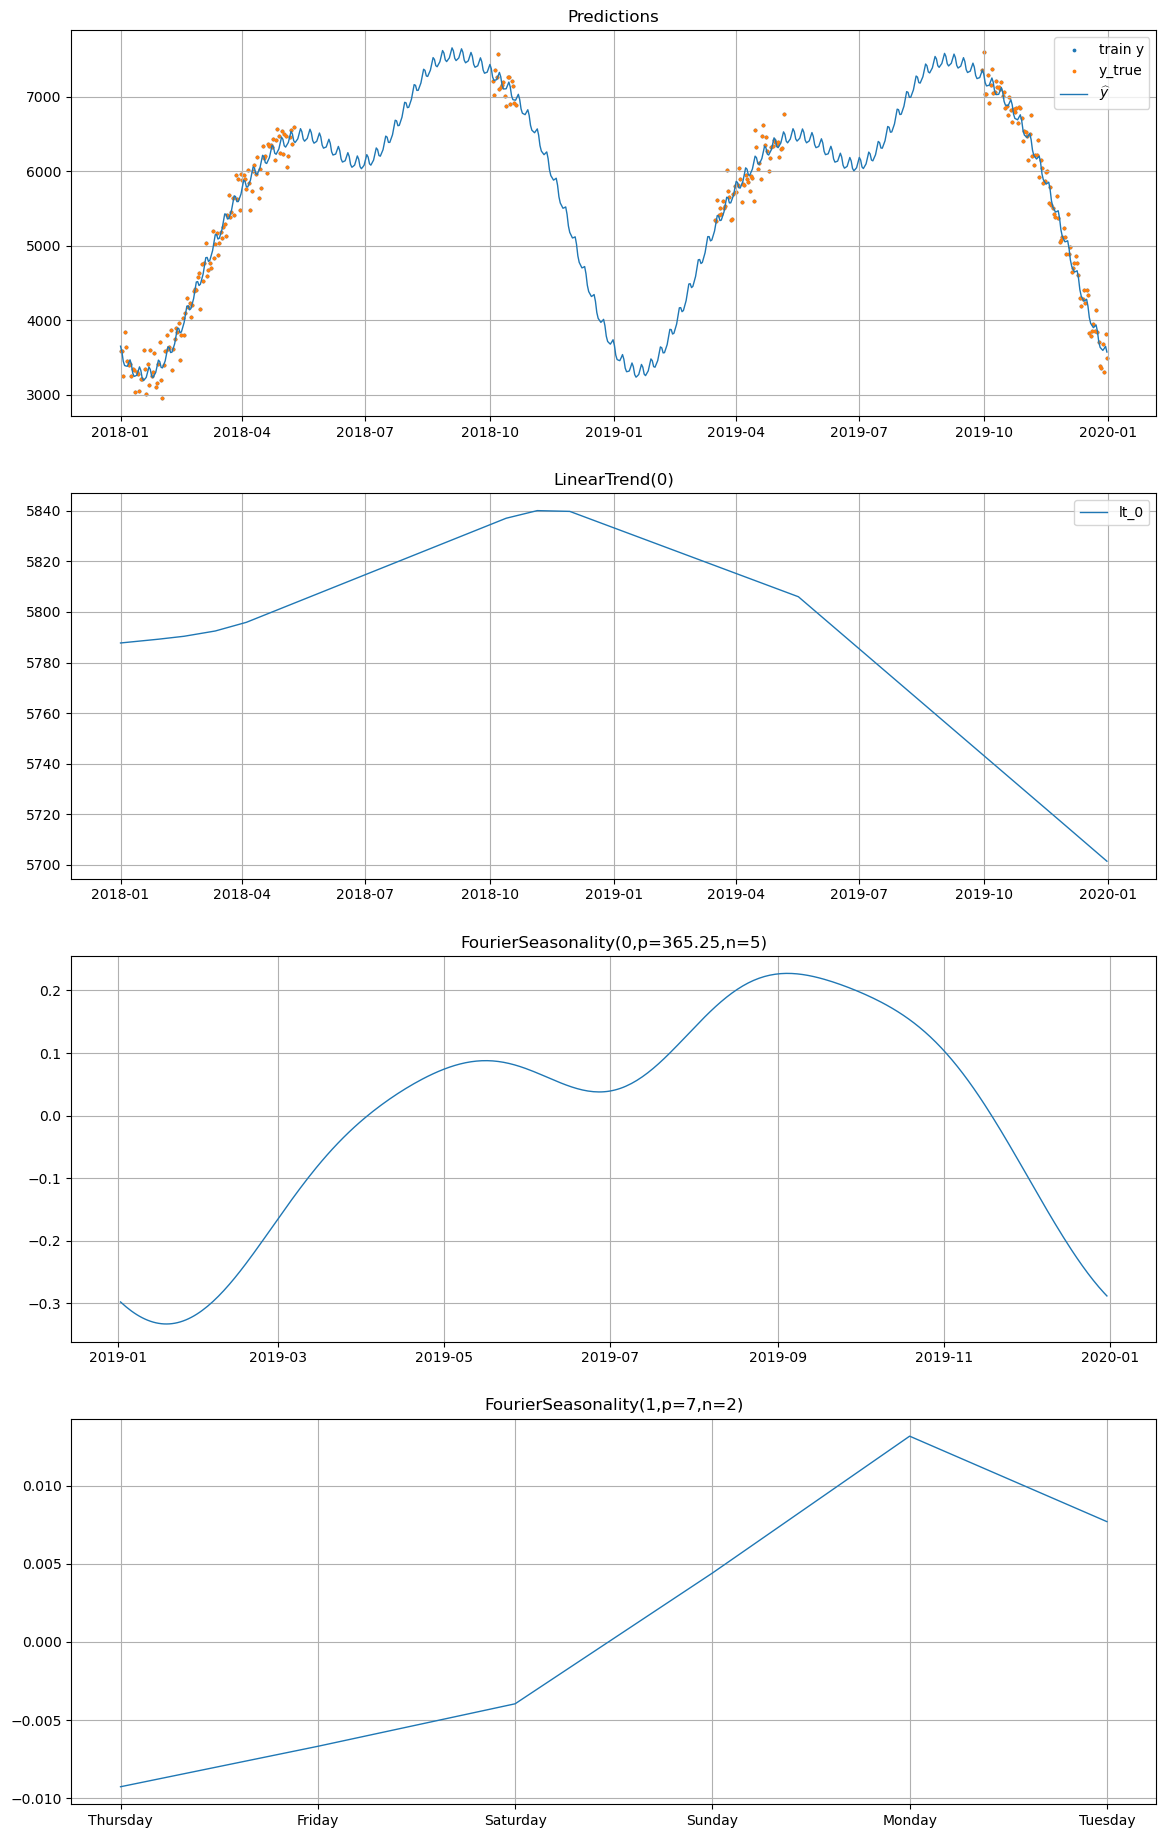

In [ ]:
# Plot partial pooling predictions for winter_2
# Compare this to the individual model's plot above — notice how
# the seasonal pattern in the gaps is smoother and more consistent.
model_partial.plot(
    future_partial, series="winter_2", y_true=df[df["series"] == "winter_2"]
)

---

## A Note on Complete Pooling

We do not demonstrate complete pooling (`pool_type="complete"`) in this notebook because it is rarely appropriate for series with different scales and opposite seasonality patterns. When all series share a single set of parameters, the model is forced to find a single compromise that fits no series well.

**However, complete pooling can be useful when:**

- All series are very similar in scale, trend, and seasonality (e.g., replicate measurements of the same process)
- You intentionally want a single "average" forecast across all series
- You have very little data per series and need maximum regularization
- You are building a baseline to compare against more flexible approaches

In our product dataset, complete pooling would try to learn one seasonal pattern for both summer and winter products — an impossible compromise that would produce poor predictions for all series.

---

## Comparison of Approaches

Let's compare individual and partial pooling side by side. Note that the **metrics alone do not tell the full story** — both approaches may show similar in-sample fit quality where data exists. The crucial difference is in the gap regions, which the metrics cannot capture since there is no ground truth there.

The comparison table below shows in-sample metrics, followed by a visual comparison of predictions for all series.

In [14]:
# Create comparison table
comparison_rows = []

for name in product_params.keys():
    comparison_rows.append(
        {
            "Series": name,
            "Group": product_params[name]["group"],
            "Approach": "Individual",
            "RMSE": individual_metrics_df.loc[name, "rmse"],
            "MAE": individual_metrics_df.loc[name, "mae"],
            "MAPE": individual_metrics_df.loc[name, "mape"],
        }
    )
    comparison_rows.append(
        {
            "Series": name,
            "Group": product_params[name]["group"],
            "Approach": "Partial",
            "RMSE": partial_metrics_df.loc[name, "rmse"],
            "MAE": partial_metrics_df.loc[name, "mae"],
            "MAPE": partial_metrics_df.loc[name, "mape"],
        }
    )

comparison_df = pd.DataFrame(comparison_rows)
print("Full Comparison:")
display(comparison_df)

Full Comparison:


,Series,Group,Approach,RMSE,MAE,MAPE
0,summer_1,summer,Individual,141.784992,114.201912,0.020858
1,summer_1,summer,Partial,142.152841,114.761139,0.020943
2,summer_2,summer,Individual,90.360999,73.274235,0.031729
3,summer_2,summer,Partial,91.518750,74.878657,0.032018
4,summer_3,summer,Individual,186.226351,144.627024,0.021537
5,summer_3,summer,Partial,186.977001,146.326295,0.021774
6,winter_1,winter,Individual,110.373320,90.463162,0.048426
7,winter_1,winter,Partial,112.821920,93.404084,0.049773
8,winter_2,winter,Individual,166.637435,131.741726,0.026308
9,winter_2,winter,Partial,166.712894,131.774282,0.026323


In [15]:
# Summary statistics by approach
summary = (
    comparison_df.groupby("Approach")
    .agg(
        {
            "RMSE": ["mean", "std"],
            "MAE": ["mean", "std"],
            "MAPE": ["mean", "std"],
        }
    )
    .round(2)
)

print("Summary Statistics by Approach:")
display(summary)

Summary Statistics by Approach:


RMSE            MAE         MAPE      
              mean    std    mean    std  mean   std
Approach                                            
Individual  132.68  38.51  105.67  29.06  0.03  0.01
Partial     133.49  38.21  106.82  28.91  0.03  0.01

In [16]:
# Timing comparison
timing_df = pd.DataFrame(
    {
        "Approach": ["Individual", "Partial"],
        "Time (s)": [time_individual, time_partial],
    }
)

print("Timing Comparison:")
display(timing_df)

Timing Comparison:


,Approach,Time (s)
0,Individual,3.451235
1,Partial,7.622211


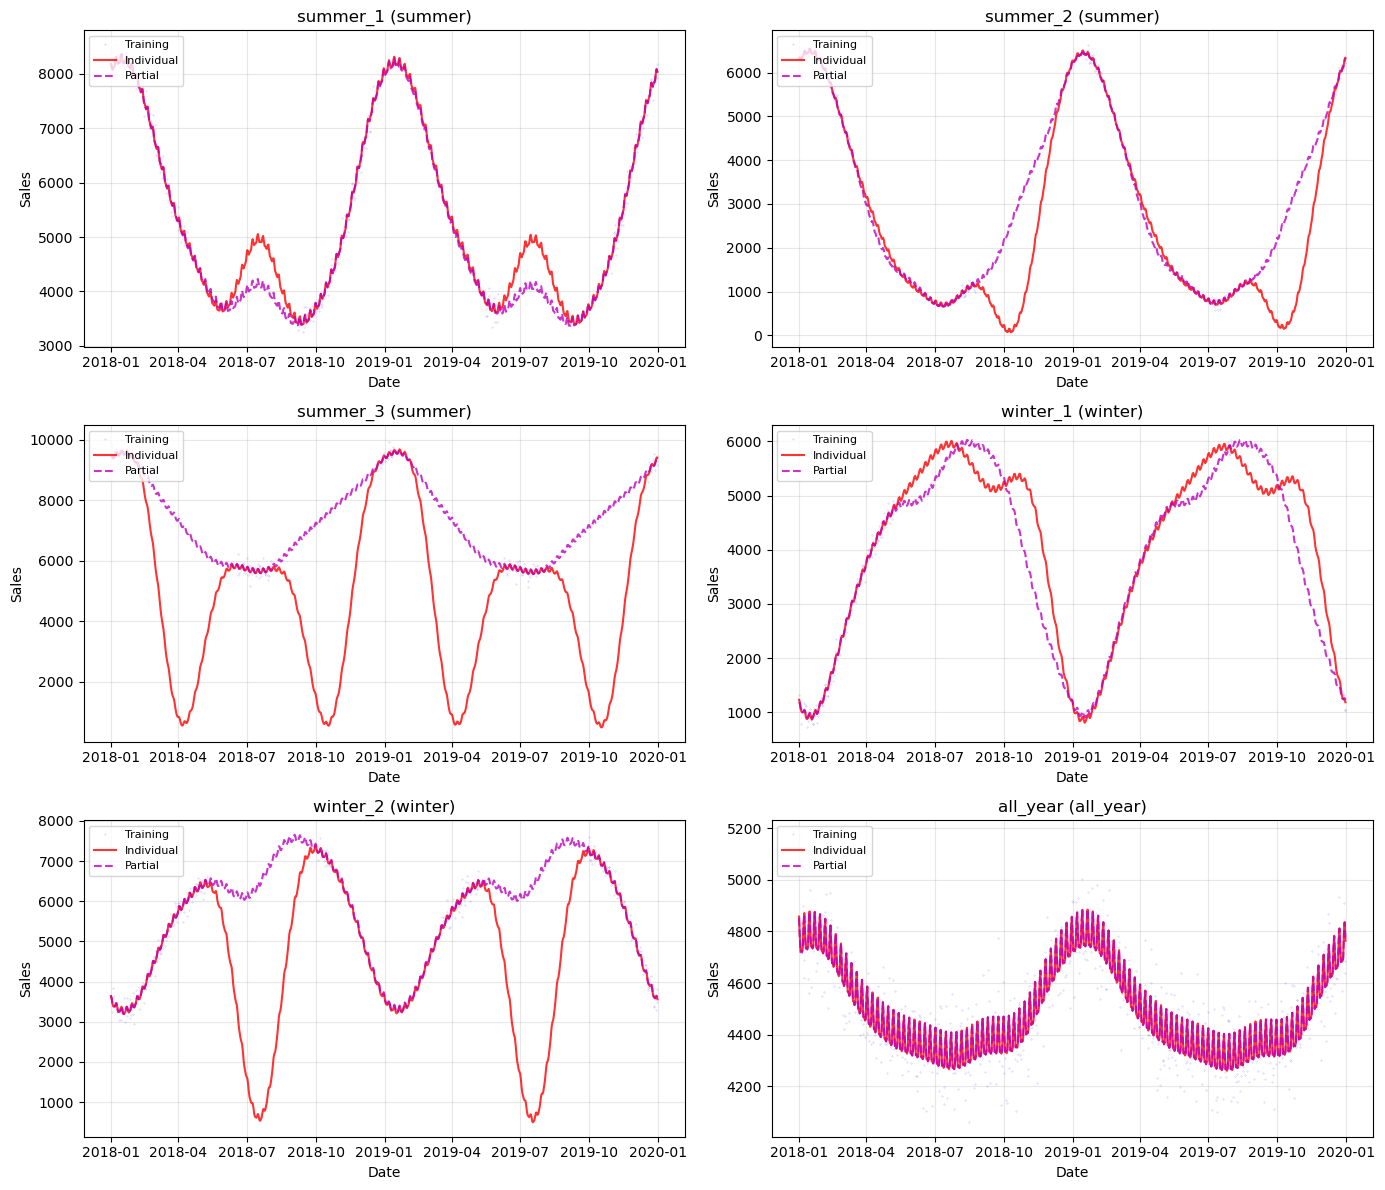

In [17]:
# Visualize predictions for each series (2 per row for better readability)
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (name, params) in enumerate(product_params.items()):
    ax = axes[i]
    train_series = df[df["series"] == name]

    # Get predictions
    ind_group = [k for k, v in model_individual.groups_.items() if v == name][0]
    par_group = [k for k, v in model_partial.groups_.items() if v == name][0]

    # Plot training data
    ax.plot(
        train_series["ds"],
        train_series["y"],
        "b.",
        markersize=0.5,
        alpha=0.3,
        label="Training",
    )
    # Plot predictions
    ax.plot(
        fitted_individual["ds"],
        fitted_individual[f"yhat_{ind_group}"],
        "r-",
        linewidth=1.5,
        alpha=0.8,
        label="Individual",
    )
    ax.plot(
        future_partial["ds"],
        future_partial[f"yhat_{par_group}"],
        "m--",
        linewidth=1.5,
        alpha=0.8,
        label="Partial",
    )

    ax.set_title(f"{name} ({params['group']})")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend(loc="upper left", fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Summary and Key Takeaways

### Why Metrics Aren't Everything

In-sample metrics (RMSE, MAE, MAPE) measure how well the model fits the **observed** data points. But when data has gaps, the real value of hierarchical modeling is in how the model fills those gaps. Individual fitting can produce arbitrarily wrong seasonal patterns in missing intervals because it has no external information to constrain the predictions. Partial pooling regularizes these predictions by sharing seasonal knowledge across series.

### Pool Types in Vangja

| Pool Type | Description | Use Case |
|-----------|-------------|----------|
| `"complete"` | All series share parameters | Very similar series, single pattern to learn |
| `"individual"` | Each series has independent parameters | Unrelated series, sufficient data per series |
| `"partial"` | Hierarchical with shared hyperpriors | Related series, want to borrow strength |

### Key Pooling Parameters

| Parameter | Description |
|-----------|-------------|
| `pool_type` | Main pooling for trend/seasonality parameters |
| `delta_pool_type` | Pooling for changepoint deltas (use with `pool_type="partial"`) |
| `sigma_pool_type` | Pooling for observation noise (pass to `fit()`) |
| `shrinkage_strength` | How strongly series are pulled toward shared mean (higher = more pooling) |

### When to Use Partial Pooling

**Use partial pooling when:**
- Series belong to natural groups (products, stores, regions)
- Some series have limited data or gaps in coverage
- You expect shared patterns across series (e.g., common seasonality)
- You want coherent predictions in missing-data intervals

**Avoid partial pooling when:**
- Series are truly independent with no shared patterns
- Each series has abundant, complete data for reliable estimation
- Computational speed is critical (partial pooling adds complexity)

### Next: Caveats of Hierarchical Modeling

In the next chapter, we explore two important caveats:

1. **Shrinkage strength is a hyperparameter** that must be tuned — different values produce meaningfully different results
2. **Opposite seasonality** (summer vs winter products) interacts with shrinkage in subtle ways, and the `UniformConstant(-1, 1)` trick from timeseers can help